### Data import

In [1]:
import pandas as pd
import seaborn as sns
import sys

data = pd.read_json('reviews-updated.json')
data.loc[:,["text"]]

,text
0,"Mto confuso, na opçao senha, nao tem , ESQUECI..."
1,Estou tendo vários problemas com esse app... D...
2,"Ruim...senha quase sempre não é reconhecida,as..."
3,"Frequentemente há o bloqueio da senha, sendo q..."
4,Vamos atualizar o processo de ativação de segu...
...,...
343,a bicha cai em golpe de pix e culpa a nubank p...
344,Nubank pra mim é o pior banco em questão de se...
345,tanto tweet falando mal da segurança do nubank...
346,caras já li tantos relatos de falha de seguran...


### Cleaning text

In [2]:
import spacy
import re
import unicodedata
import string

def setup_abbr():
    file = open("abbr_portuguese.txt", encoding='utf-8')
    abbr_dict = {}

    for line in file:
        w = line.split(";")
        abbr_dict[w[0]] = w[1].replace("\n", "")
    file.close()

    return abbr_dict

def clean(data):
    doc = nlp(data)
    doc_lower = doc.text.lower()
    punct = string.punctuation
    for c in punct:
        doc_lower = doc_lower.replace(c, "")
    doc_without_emoji = emoji_pattern.sub(r'', doc_lower)
    doc_punctuation = u"".join([c for c in unicodedata.normalize('NFKD', doc_without_emoji) if not unicodedata.combining(c)])
    doc_corrected = nlp(" ".join([abbr_dict.get(w, w) for w in doc_punctuation.split()]))
    
    return doc_corrected.text

nlp = spacy.load('pt_core_news_sm')
abbr_dict = setup_abbr()
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

data['cleaned_reviews'] = data['text'].apply(clean)
data.loc[:,["cleaned_reviews"]]

,cleaned_reviews
0,muito confuso na opcao senha nao tem esqueci s...
1,estou tendo varios problemas com esse aplicati...
2,ruimsenha quase sempre nao e reconhecidaassina...
3,frequentemente ha o bloqueio da senha sendo qu...
4,vamos atualizar o processo de ativacao de segu...
...,...
343,a bicha cai em golpe de pix e culpa a nubank p...
344,nubank pra mim e o pior banco em questao de se...
345,tanto tweet falando mal da seguranca do nubank...
346,caras ja li tantos relatos de falha de seguran...


### Tagging

In [3]:
import joblib
from nltk import word_tokenize

def wordTag(text):
    tagger = joblib.load('POS_tagger_brill.pkl')
    text = tagger.tag(word_tokenize(text))
    return text
 
data['tag_reviews'] = data['cleaned_reviews'].apply(wordTag)
data.loc[:,["cleaned_reviews", "tag_reviews"]]

,cleaned_reviews,tag_reviews
0,muito confuso na opcao senha nao tem esqueci s...,"[(muito, ADV), (confuso, ADJ), (na, KS), (opca..."
1,estou tendo varios problemas com esse aplicati...,"[(estou, V), (tendo, V), (varios, N), (problem..."
2,ruimsenha quase sempre nao e reconhecidaassina...,"[(ruimsenha, N), (quase, ADV), (sempre, ADV), ..."
3,frequentemente ha o bloqueio da senha sendo qu...,"[(frequentemente, ADV), (ha, N), (o, ART), (bl..."
4,vamos atualizar o processo de ativacao de segu...,"[(vamos, VAUX), (atualizar, V), (o, ART), (pro..."
...,...,...
343,a bicha cai em golpe de pix e culpa a nubank p...,"[(a, ART), (bicha, N), (cai, V), (em, PREP), (..."
344,nubank pra mim e o pior banco em questao de se...,"[(nubank, NPROP), (pra, PREP), (mim, PROPESS),..."
345,tanto tweet falando mal da seguranca do nubank...,"[(tanto, KC|[), (tweet, NPROP), (falando, V), ..."
346,caras ja li tantos relatos de falha de seguran...,"[(caras, ADJ), (ja, N), (li, V), (tantos, PROA..."


### Tokenization

In [4]:
import nltk
from nltk.tokenize import word_tokenize

def tokenize(text):
    text = word_tokenize(text)
    return text

data['tokenized_reviews'] = data['cleaned_reviews'].apply(tokenize)
data.loc[:,["tokenized_reviews"]]

,tokenized_reviews
0,"[muito, confuso, na, opcao, senha, nao, tem, e..."
1,"[estou, tendo, varios, problemas, com, esse, a..."
2,"[ruimsenha, quase, sempre, nao, e, reconhecida..."
3,"[frequentemente, ha, o, bloqueio, da, senha, s..."
4,"[vamos, atualizar, o, processo, de, ativacao, ..."
...,...
343,"[a, bicha, cai, em, golpe, de, pix, e, culpa, ..."
344,"[nubank, pra, mim, e, o, pior, banco, em, ques..."
345,"[tanto, tweet, falando, mal, da, seguranca, do..."
346,"[caras, ja, li, tantos, relatos, de, falha, de..."


### Stopwords remove

In [22]:
from nltk.corpus import stopwords
from spacy.lang.pt.stop_words import STOP_WORDS

def stopwordsRemove(text):
    STOP_WORDS.update(['nao', 'sim', 'caixa', 'nubank', 'banco', 'pra', 'pro', 'ta', 'ja', 'so'])
    stop_words = list(set(stopwords.words('portuguese') + list(STOP_WORDS)))
    phrase = []
    for word in text:
        if word not in stop_words:
            phrase.append(word)
    return phrase

data['stopwords_reviews'] = data['tokenized_reviews'].apply(stopwordsRemove)
data.loc[:,["stopwords_reviews"]]

,stopwords_reviews
0,"[confuso, opcao, senha, esqueci, senha]"
1,"[tendo, varios, problemas, aplicativo, digitan..."
2,"[ruimsenha, quase, reconhecidaassinatura, elet..."
3,"[frequentemente, ha, bloqueio, senha, sendo, a..."
4,"[vamos, atualizar, processo, ativacao, seguran..."
...,...
343,"[bicha, cai, golpe, pix, culpa, opcoes, segura..."
344,"[mim, pior, questao, seguranca, dia, alguem, t..."
345,"[tweet, falando, seguranca, fico, feliz, aband..."
346,"[caras, li, tantos, relatos, falha, seguranca,..."


### Frequency Word

['golpe', 'aplicativo', 'seguranca', 'senha', 'conta', 'pix', 'cartao', 'celular', 'dinheiro', 'roubo']


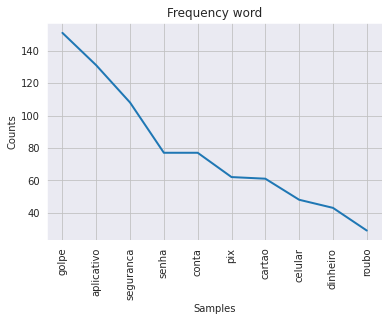

In [23]:
import matplotlib.pyplot as plt

dataList = data['stopwords_reviews'].to_list()

strList = []

for i in range(len(dataList)):
    for j in range(len(dataList[i])):
        strList.append(dataList[i][j])

sns.set_style('darkgrid')
nlp_words=nltk.FreqDist(strList)

mostCommon = []

for word, frequency in nlp_words.most_common(10):
    mostCommon.append(word)

print(mostCommon)

nlp_words.plot(10, title='Frequency word');

### Stemming

In [ ]:
import nltk
from nltk.stem import RSLPStemmer

def stemming(text):
    stemmer = RSLPStemmer()
    phrase = []
    for word in text:
        phrase.append(stemmer.stem(word))
    return phrase

data['stem_reviews'] = data['tokenized_reviews'].apply(stemming)
data.loc[:,["stem_reviews"]]

### Lemmatizer

In [ ]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    lemma = " "
    for word in text:
        lemma = wordnet_lemmatizer.lemmatize(word)
        
    return lemma

data['lemma_reviews'] = data['stopwords_reviews'].apply(lemmatize)
data.loc[:,["lemma_reviews"]]

### Phrase junction

In [ ]:
def juction(text):
    phrase = []
    for word in text:
        phrase.append(word)
    
    phraseStr = ' '.join(phrase)
    return phraseStr

data['junction'] = data['stem_reviews'].apply(juction)
data.loc[:,["junction"]]

### Word Cloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

comment_words = ''
stopwords = set(STOPWORDS)
stopwords.update(["a", "e", "i", "o", "u", "da", "em", "meu", "minha", "mais", "menos", "você", "de", "ao", "os", "para", "vai", "sim", "não", "que", "eu", "ele", "ela", "pra", "pro", "na", "no", "muito"])

# iterate through the json file
for val in data['junction']:
	
	# typecaste each val to string
	val = str(val)

	# split the value
	tokens = val.split()
	
	# Converts each token into lowercase
	for i in range(len(tokens)):
		tokens[i] = tokens[i].lower()
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


### Information extraction

In [ ]:
import spacy
from spacy.matcher import PhraseMatcher

nlp = spacy.load('pt_core_news_sm')

def informationExtraction(text):
    evaluations = []
    doc = nlp(text)
    
    securityTerms = ['segur', 'roub', 'clon', 'senh', 'acess']
    patterns = [nlp(term) for term in securityTerms]
    
    #Ver utilização do add_patterns juntamente com o entity_ruler (otimização)
    matcher = PhraseMatcher(nlp.vocab) 
    matcher.add("SECURITY_PATTERN", patterns)
    
    matches = matcher(doc)
    
    for i in range(0,len(matches)):
        token = doc[matches[i][1]:matches[i][2]]
        evaluations.append(str(token))
            
    return evaluations

data['extracted_reviews'] = data['junction'].apply(informationExtraction)

In [ ]:
for i in range(len(data)):
    if len(data.loc[i,'extracted_reviews'])!=0:
        print(data.loc[i,'cleaned_reviews'])